Copyright (C) 2023 Pablo Castells y Alejandro Bellogín

El código que contiene este notebook se ha implementado para la realización de las prácticas de la asignatura "Búsqueda y minería de información" de 4º del Grado en Ingeniería Informática, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Búsqueda y Minería de Información 2022-23**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso

# Bloque 1 &ndash; Sistemas de recomendación

Fechas:

* Comienzo: martes 28 / jueves 30 de marzo.
* Entrega: lunes 8 de mayo, 23:59.

## Objetivos

Este primer bloque de la práctica tiene por objetivo la implementación y evaluación eficiente de sistemas de recomendación. En este bloque se desarrollarán:

* Estructuras para el manejo de datos de interacción entre usuarios e items ("ratings" para simplificar).
* Algoritmos de recomendación basada en filtrado colaborativo.
* Métricas de evaluación de sistemas de recomendación.

## Material proporcionado

Se proporcionan software y datos para la realización de la práctica:

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. 
  - De modo similar a las prácticas anteriores, se proporciona una celda de prueba al final de este notebook que deberá funcionar con las implementaciones del estudiante.
  - Junto a la celda de prueba en este mismo notebook, se muestra como referencia un ejemplo de salida generada con una implementación de los profesores.
* Los siguientes conjuntos de datos de ratings por usuarios a items:
  - Dos conjuntos de juguete para prueba y depuración: <ins>toy1.csv</ins> (se genera en Matrices.ipynb) y <ins>toy2.csv</ins> (proporcionado en el curso Moodle) con ratings ficticios.
  - Un conjunto de datos reales de ratings a películas: *ml-1m.zip* disponible en la Web de [MovieLens](https://grouplens.org/datasets/movielens/1m). De los archivos disponibles, se utilizará sólamente <ins>ratings.dat</ins>, añadiéndole una cabecera `u::i::r::t`.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

## Calificación

El peso de esta práctica (recomendación + redes sociales) en la nota final de prácticas es del **40%**.

La calificación se basará en el **número** de ejercicios realizados y la **calidad** de los mismos. La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan. El profesor comprobará este aspecto ejecutando la celda de prueba y otras adicionales.

La corrección de las implementaciones se observará por la **coherencia de los resultados** (por ejemplo, las métricas sobre los algoritmos de recomendación), y se valorará la eficiencia en tiempo de ejecución.

## Entrega

La entrega consistirá en dos ficheros tipo *notebook* (uno para recomendación y otro para redes sociales) donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

## Indicaciones

La realización de los ejercicios conducirá en muchos casos a la implementación de funciones y/o clases adicionales a las que se indican en el enunciado. Algunas vendrán dadas por su aparición en los propias celdas de prueba, y otras por conveniencia a criterio del estudiante.

Igual que en prácticas anteriores, no deberán editarse las celdas de prueba. Estas celdas deberán ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado.

## Ejercicio 1: Estructuras de datos y recomendación simple (2.5pt)

#### 1.1 &nbsp; Estructuras de datos

Implementar las clases necesarias para manejar **datos de entrada y prueba** (ratings) para los algoritmos de recomendación. La funcionalidad se implementará en una clase Ratings, que permitirá leer los datos de un fichero de texto, así como un método que genere dos particiones aleatorias de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación.

In [296]:
import numpy as np
import pandas as pd
import copy
from io import StringIO

class Ratings:
    def __init__(self, file, sep=','):
        self.file = file
        self.sep = sep
        self.df = pd.read_csv(file, sep=sep)
        self.df = self.df[['u', 'i', 'r']]
        self.df.columns = ['uid', 'iid', 'rating']
        self.df = self.df.sort_values(by=['uid', 'iid'])
        self.uids = self.df.uid.unique()
        self.iids = self.df.iid.unique()
        self.m = np.zeros((self.nusers(), self.nitems()))
        for row in self.df.itertuples():
            self.m[self.uid_to_uidx(row.uid), self.iid_to_iidx(row.iid)] = row.rating
        

    def matrix(self):
        return self.m
    
    def nusers(self):
        return len(self.uids)
    
    def nitems(self):
        return len(self.iids)
    
    # uidx can be an int or an array-like of ints.
    def uidx_to_uid(self, uidx):
        return self.uids[uidx]
        
    # iidx can be an int or an array-like of ints.
    def iidx_to_iid(self, iidx):
        return self.iids[iidx]
    
    # uid can be an int or an array-like of ints.
    def uid_to_uidx(self, uid):
        return np.where(self.uids == uid)
        
    # iid can be an int or an array-like of ints.
    def iid_to_iidx(self, iid):
        return np.where(self.iids == iid)
        
    def iidx_rated_by(self, uidx):
        return self.m[uidx, :]
        
    def uidx_who_rated(self, iidx):
        return self.m[:, iidx]

        
    def random_split(self, ratio):
        values          = self.m.flatten()
        non_cero        = np.nonzero(values)[0]
        ammount        = int(len(non_cero) * ratio)
        test_idx        = np.random.choice(non_cero, ammount, replace=False)

        test          = np.zeros_like(self.m)
        for i in test_idx:
            row         = i // self.m.shape[1]
            col         = i % self.m.shape[1]
            test[row, col] = values[i]

        training          = np.zeros_like(self.m)
        for i in non_cero:
            if i not in test_idx:
                row         = i // self.m.shape[1]
                col         = i % self.m.shape[1]
                training[row, col] = values[i]
        self.test = copy.copy(self)
        self.test.m = test
        self.training = copy.copy(self)
        self.training.m = training
        return (self.test, self.training)
    
    #
    # The remaining functions are just for debugging purposes
    #

    def rating(self, uid, iid):
        uidx = self.uid_to_uidx(uid)
        iidx = self.iid_to_iidx(iid)
        return self.m[uidx, iidx]

    def items_rated_by(self, uid):
        uidx = self.uid_to_uidx(uid)
        rated_items = np.where(self.m[uidx, :] != 0)[0]
        return [self.iidx_to_iid(iidx) for iidx in rated_items]
        
    def users_who_rated(self, iid):
        iidx = self.iid_to_iidx(iid)
        return np.nonzero(self.uidx_who_rated(iidx))[0]
    
    def user_ratings(self, uid):
        uidx = self.uid_to_uidx(uid)
        return np.count_nonzero(self.m[uidx])
    
    def item_ratings(self, iid):
        iidx = self.iid_to_iidx(iid)
        return np.count_nonzero(self.m[:, iidx])
    
    def nratings(self):
        return len(self.df)
        
    # To inspect random data splits.
    def save(self, file):
        df = pd.DataFrame(columns=self.iids, index=self.uids, data=self.m).unstack().reset_index(name='r')
        df.columns = ['i', 'u', 'r']
        df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'])
        df.to_csv(file, index=False)

# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

#### 1.2 &nbsp;  Recomendaciones: métodos simples no personalizados

La **salida** de un recomendador consistirá en un diccionario con un ránking por usuario. 

Implementar un primer **recomendador simple** por rating promedio en una clase `AverageRecommender`. El recomendador sólo recomendará items que tengan un mínimo número de ratings, que se indicará como parámetro en el constructor (con ello se mejora el acierto de la recomendación). Se proporciona una clase `MajorityRecommender` a modo de ejemplo en el que el estudiante podrá basarse, así como `RandomRecommender`, que se utiliza en ocasiones como referencia en experimentos. 

**Importante**: recordar que no deben recomendarse los items que los usuarios ya hayan puntuado.

In [317]:
# Suggestion: compute the scores in each recommenders' constructor.
from itertools import islice

# Given a matrix, returns a matrix of positions of top k values per row.
def top_positions_per_row(m, k):
    return np.argpartition(m, -k)[:, -k:]

class Recommendation:
    def __init__(self, scores, n, training):
        self.scores         = scores
        self.n              = n
        self.training       = training
        
        top_iidx = np.sort(top_positions_per_row(self.scores, self.n))
        self.ranked_iidx = np.take_along_axis(top_iidx, np.argsort(np.take_along_axis(-self.scores, top_iidx, axis=1)), axis=1)
        self.ranked_iids = training.iidx_to_iid(self.ranked_iidx)
        self.rank_scores = np.take_along_axis(scores, self.ranked_iidx, axis=1)
        self.scores[self.training.matrix()!=0]=0

    def ranked_iidx(self):
        return self.ranked_iidx
        
    def recommendation(self, uid):
        return np.take_along_axis(self.scores, top_positions_per_row(self.scores, uid), axis = 1)
        
    # This function is for debuggind purposes.
    # Format the recommendation as a string for the first n users. Trim scores to 4 decimal digits.
    def display(self, n):
        # print(self.scores)
        output=''
            
        for u in range(n):
            output+=('user '+str(u+1)+'\t')
            for col in range(n):
                output+=(str(round(self.scores[u][col], 4))+'\t')
            output+=('...\n')
        output+=('...')
        return output

class Recommender():
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    def recommend(self, n):
        return Recommendation(self.scores, n, self.training)

class RandomRecommender(Recommender):
    def __init__(self, training):
        super().__init__(training)
        self.scores = np.random.random(training.matrix().shape)

class MajorityRecommender(Recommender):
    def __init__(self, training, threshold=0):
        super().__init__(training)
        # training.matrix() >= threshold creates a mask with 'True' on relevant ratings and 'False' anywhere
        # else. Thus 'pop' is an array with the counts of relevant ratings of each item.
        pop = np.sum(training.matrix() >= threshold, axis=0)
        # This product by a vector of ones (of user-row length) creates a matrix where the pop vector gets
        # copied on all rows; the recommendation is not personalized and ranking is the same for all users 
        # -- except of course in the end different training items will be filtered out for different users.
        self.scores = np.outer(np.ones(training.nusers()), pop)

class AverageRecommender(Recommender):
    def __init__(self, training, minr=0):
        super().__init__(training)
        self.num_reviews = np.sum(training.matrix() > 0, axis=0)
        self.mean_ratings = 0
        no_zero_num_reviews = self.num_reviews[self.num_reviews == 0] =1
        self.mean_ratings = np.sum(training.matrix(), axis=0)/no_zero_num_reviews
        self.mean_ratings[self.num_reviews < minr] = 0
        self.scores = np.outer(np.ones(training.nusers()), self.mean_ratings)
    

### Ejercicio 1 &ndash; Explicación/documentación

##### 1.1 &nbsp; Estructuras de datos
La clase `Ratings` nos permite hacer cosas como leer datos de un archivo y separarlos en conjuntos de entrenamiento y prueba de forma aleatoria con un random split. También cuenta con varios métodos que nos permiten obtener información útil de dichos ratings, como el número de calificaciones que tiene un usuario o un elemento en particular. En resumen, la clase "Ratings" es útil para trabajar con datos de calificaciones y nos permite hacer varias operaciones básicas.

##### 1.2 &nbsp;  Recomendaciones: métodos simples no personalizados
Hemos creado la clase `Recommendation`. Esta se utiliza para obtener recomendaciones de ítems para cada usuario. La clase toma como entrada los puntajes, el número de recomendaciones que se desean y los datos de entrenamiento. Utiliza los puntajes para calcular los índices de los ítems con las mejores puntuaciones y clasificarlos según la preferencia del usuario. Luego, utiliza una máscara para eliminar los ítems que ya han sido clasificados en los datos de entrenamiento y devuelve las recomendaciones para los ítems no vistos. En resumen, esta clase sirve para obtener recomendaciones de ítems que cada usuario aún no ha evaluado.

## Ejercicio 2: Filtrado colaborativo kNN (2.5pt)

Implementar un algoritmo de filtrado colaborativo mediante vecinos próximos orientado a usuarios por *similitud coseno* (sin normalizar por la suma de similitudes). 

In [304]:
from math import sqrt

class CosineUserSimilarity:
    def __init__(self, training):
        self.training = training

    def calculate(self):
        result_matrix = np.dot(self.training.matrix(), self.training.matrix().T)
        self.output = np.zeros_like(result_matrix)
        n_rows, n_columns = self.training.matrix().shape 
        for x in range(n_rows):
            for y in range(n_rows):
                self.output[x][y] = result_matrix[x][y]/(sqrt(result_matrix[x][x])*sqrt(result_matrix[y][y]))
        return self.output


class UserKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)
        self.training = training
        self.k = k
        self.sim = sim
        cos = self.sim.calculate()
        np.fill_diagonal(cos, 0)
        temporal_scores = np.dot(cos, self.training.matrix())
        uidx = top_positions_per_row(temporal_scores, self.k)
        mask = np.zeros_like(temporal_scores)
        mask[np.arange(mask.shape[0]), uidx.T] = 1
        self.scores = temporal_scores * mask

### Ejercicio 2 &ndash; Explicación/documentación

El filtrado colaborativo kNN se divide en dos fases:
- `CosineUserSimilarity` :  se encarga de calcular la similitud entre usuarios utilizando la medida del coseno. Primero, se crea una matriz resultado que es el producto punto entre la matriz de entrenamiento y su transpuesta. Luego, se itera sobre los elementos de la matriz resultado para calcular la similitud coseno entre cada par de usuarios y se almacena en self.output.

- `UserKNNRecommender` : implementa un recomendador basado en vecinos cercanos (KNN) de usuarios utilizando la similitud calculada por CosineUserSimilarity. Primero, se calcula la similitud coseno utilizando la matriz de entrenamiento y se elimina la diagonal para evitar que un usuario sea similar a sí mismo. Luego, se multiplica la similitud por la matriz de entrenamiento para obtener una matriz temporal de puntuaciones a la que se le aplica una máscara para solo obtener los k vecinos con mayor puntuacion  y con ello las puntuaciones finales para cada usuario y item, que se almacenan en self.scores.

En resumen, la clase de filtrado colaborativo KNN utiliza la similitud coseno para encontrar los usuarios más cercanos a cada usuario y luego usa el recomendador para proveer scores finales de recomendación para cada usuario.


## Ejercicio 3: Evaluación (1.5pt)

Se desarrollarán clases que permitan calcular métricas para evaluar y comparar el acierto de los recomendadores: se implementarán **precisión** y **recall**. 

Como resumen de este bloque, se incluirá una *tabla con los valores de las métricas* (dos columnas) más el tiempo de ejecución (una columna más) sobre todos los algoritmos implementados (filas), al menos para el conjunto de datos de <ins>MovieLens 1M</ins>. En el caso de ser capaces de procesar un conjunto de datos más grande, se documentará el tamaño en RAM de la matriz de ratings.

<!-- Opcionalmente, se podrán implementar otras métricas a elección del estudiante (nDCG, etc.), cuya prueba se incluirá en la función `student_test()` del ejercicio 4 ("ampliaciones"). -->

In [305]:
class Metric():
    def __init__(self, test, cutoff):
        self.test = test
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ('@' + str(self.cutoff) if self.cutoff != np.inf else '')
    

class Precision(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(test, cutoff)
        self.threshold = threshold
        self.cutoff = cutoff
        self.test = test


    def compute(self, recommendation):
        n_rows, n_cols = self.test.matrix().shape
        returned = min(self.cutoff, n_cols)
        res = 0
        relevant_returned = 0
        for i in range(n_rows):
            row = np.argpartition(recommendation.scores[i], -returned)[-returned:]
            relevant_returned = 0
            for j in range(returned):
                test_value = self.test.matrix()[i][row[j]]
                if test_value!=0 and recommendation.scores[i][row[j]]>self.threshold: 
                    relevant_returned += 1
            res += relevant_returned / returned
        res = res / n_rows
        return res

        
        

class Recall(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(test, cutoff)
        self.threshold = threshold
        self.cutoff = cutoff
        self.test = test
        

    def compute(self, recommendation):
        n_rows, n_cols = self.test.matrix().shape
        returned = min(self.cutoff, n_cols)
        res = 0
        relevant_returned = 0
        for i in range(n_rows):
            row = np.argpartition(recommendation.scores[i], -returned)[-returned:]
            relevants = np.count_nonzero(self.test.matrix()[i])
            if relevants==0: continue
            #print(recommendation.scores[i][row])
            relevant_returned = 0
            for j in range(returned):
                test_value = self.test.matrix()[i][row[j]]
                if test_value!=0 and recommendation.scores[i][row[j]]>self.threshold: 
                    relevant_returned += 1
            res += relevant_returned / relevants
        res = res / n_rows
        return res

### Ejercicio 3 &ndash; Explicación/documentación

En este ejercicio creamos las clases que se utilizarn para evaluar la calidad de los resultados de un recomendador mediante diferentes métricas de evaluación.

- `Metric` : la clase base para todas las métricas.

- `Precision` : Una subclase de `Metric` que se utiliza para calcular la precisión de los resultados del recomendador (P@k). Toma tres argumentos: el conjunto de datos de prueba test, el límite superior de los elementos recomendados cutoff y el umbral de relevancia threshold. La precisión se define como la proporción de elementos relevantes recomendados en relación con el número total de elementos recomendados.

- `Recall` : Una subclase de `Metric` que se utiliza para calcular el recall de los resultados del recomendador. Toma los mismos tres argumentos que `Precision`. El recall se define como la proporción de elementos relevantes recomendados en relación con el número total de elementos relevantes en el conjunto de prueba.

Ambas clases Precision y Recall tienen un método compute que toma un objeto de recomendación y devuelve un número que representa la métrica correspondiente (precisión o recall).


||Precision@3|Recall@3|Tiempo de ejecución (ms)
|-|:-:|:-:|:-:
|RandomRecommender|0.0105|0.0008|320.17
|MajorityRecommender|0.2270|0.0265|132.98
|AverageRecommender|0.2272|0.0268|127.97
|UserKNNRecommender|0.1043|0.0158|139.35
|MF|0.4342|0.0618|244.59

## Ejercicio 4: Ampliaciones (1.5pt)

Elegir uno de los siguientes ejercicios:

* Implementar dos variantes de kNN a elección del estudiante, por ejemplo: kNN normalizado, vecinos próximos orientado a item, similitud de Pearson, kNN centrado en la media. Indicación: para kNN normalizado el algoritmo exigirá un mínimo de ratings de vecinos para aceptar recomendar un item (con ello se mejora el acierto de la recomendación, de forma similar a la recomendación por rating promedio).

* #### _**Implementar filtrado colaborativo mediante factorización de matrices.**_
* Crear una implementación de las estructuras de ratings con matrices dispersas, de forma que sea posible generar recomendaciones sobre conjuntos de datos más grandes, tales como [MovieLens 10M](https://grouplens.org/datasets/movielens/10m) y [MovieLens 25M](https://grouplens.org/datasets/movielens/25m).

Para probar las implementaciones deberá completarse la función `student_test()` para ilustrar la ejecución de las variantes adicionales, y se incluirán las filas que correspondan en la tabla del apartado anterior.

In [307]:
ratings = Ratings("recsys-data/ratings-1m.dat", '::')
np.random.seed(0)
train, test = ratings.random_split(.8)
np.random.seed(0)

/tmp/ipykernel_21446/3316909838.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(file, sep=sep)


Training MF --> Epochs: 150  Training error: 0.32544658883287075 Test Precision@10: 0.032632450331125495 [0:01:57]              


(array([[-0.07536429, -0.04508348,  0.04724897, ...,  0.31310704,
          0.11584064,  0.25168202],
        [ 0.10010969, -0.1568965 ,  0.06126884, ...,  0.28907749,
          0.26152343,  0.06601479],
        [ 0.22961   , -0.10852169,  0.20306368, ...,  0.07772654,
          0.08060628,  0.01855665],
        ...,
        [-0.01579628, -0.03382831, -0.01942343, ...,  0.00136154,
          0.03005364,  0.0016197 ],
        [ 0.17021184,  0.11501265,  0.35210112, ..., -0.0016321 ,
          0.30816138, -0.27744207],
        [ 0.02340612,  0.19318441, -0.24327455, ...,  0.2494491 ,
          0.63852622,  0.02304771]]),
 array([[-5.05508222e-01, -7.56758749e-01, -5.84906823e-01, ...,
          2.28654864e+00,  1.32403328e-01,  1.23036876e+00],
        [-2.10328245e-01, -1.97132678e-01,  1.15170757e-01, ...,
          5.07461379e-01,  2.55475771e-01,  2.07020168e-01],
        [ 2.34782123e-01,  1.02912311e-01,  7.20827544e-02, ...,
          8.22983747e-01,  2.04742454e-01,  1.25794871e+

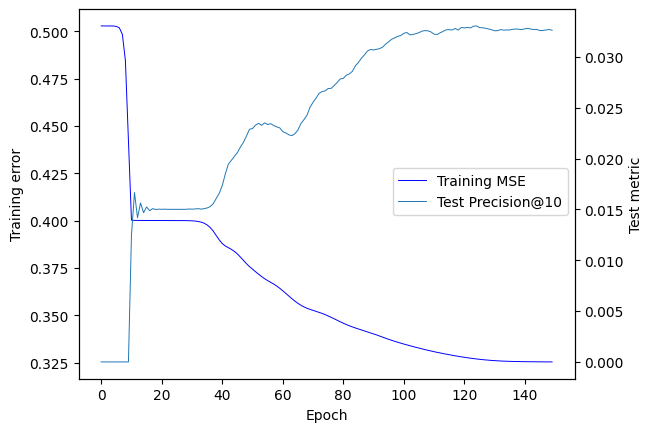

In [308]:
from matplotlib import pyplot as plt
import datetime, time

def plot(train_losses, test_metrics=None, test_metrics_results=None):
    f = plt.figure()
    plt.plot(range(len(train_losses)), train_losses, color='blue', linewidth=.7, label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Training error')
    for i, tm in enumerate(test_metrics):
        plt.gca().twinx().plot(range(len(test_metrics_results[i])), 
                            test_metrics_results[i], linewidth=.7, label=f'Test {tm}')
        plt.ylabel('Test metric')
    f.legend(loc='center right', bbox_to_anchor=(0.9, 0.5))
        
class MF(Recommender):
    def __init__(self, training, dim=20, lrate=.0005, nepochs=150, test_metrics=[], drawPlot=True):
        super().__init__(training)
        self.scores = np.zeros(training.matrix().shape)
        self.drawPlot = drawPlot
        self.dim = dim
        self.lrate = lrate
        self.nepochs = nepochs
        self.test_metrics = test_metrics
        
    def predict(self, p, q):
        return p @ q.T
        
    def train(self):

        p = abs(np.random.normal(scale=1/self.training.nusers(), size=(self.training.nusers(), self.dim)))
        q = abs(np.random.normal(scale=1/self.training.nitems(), size=(self.training.nitems(), self.dim)))
        
        test_metrics_results = []
        for test_metric in self.test_metrics:
            test_metrics_results.append([])

        errors = []
        # Binarizamos los ratings de entrenamiento.
        start = time.time()
        for epoch in range(self.nepochs):
            self.scores = self.predict(p, q)
            err = self.training.matrix() - self.scores
            p += self.lrate * (err @ q - 0.1 * p)
            q += self.lrate * (err.T @ p - 0.1 * q)
            
            e = (err**2).mean()
            if self.test_metrics!=[]: 
                if self.drawPlot:
                    printer=''
                    for i, tm in enumerate(self.test_metrics):
                        m = tm.compute(self.recommend(test_metric.cutoff))
                        test_metrics_results[i].append(m)
                        printer += f' Test {tm}: {m}'
                        print(f'\rTraining MF --> Epochs: {epoch+1}  Training error: {e}{printer} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='              ')
                else:
                    print(f'\rTraining MF --> Epochs: {epoch+1} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='              ')

            else:
                print(f'\rTraining MF --> Epochs: {epoch+1}  Training error: {e} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='              ')
            errors.append(e)
        if self.drawPlot:
            print()
            plot(errors, self.test_metrics, test_metrics_results)
        return p, q



mf = MF(train, dim=20, lrate=.0005, nepochs=150, test_metrics=[Precision(test, cutoff=10, threshold=4)])
mf.train()


El plot esta guardado en el archivo `MFPlot.png`

In [309]:
import time
from termcolor import colored

def timer(start):
    print(colored(f'\t--> elapsed time: {round((time.time() - start)*1000, 2)} ms <--', 'blue'))
    return time.time()

def student_test(training, test, n, threshold):
    recommenders = [RandomRecommender(training), MajorityRecommender(training, threshold=3), AverageRecommender(
        training, minr=3), UserKNNRecommender(training, CosineUserSimilarity(training), 3), MF(training, dim=20, lrate=.0005, nepochs=150, test_metrics=[], drawPlot=False)]
    metrics = [(Precision(test, cutoff=n, threshold=threshold), 'red'), (Recall(test, cutoff=n, threshold=threshold), 'green')]

    recommenders[4].train()
    print("\n")
    for recommender in recommenders:
        print("Testing", recommender)
        start = time.time()
        recommendation = recommender.recommend(3)
        timer(start)
        for metric in metrics:
            print(colored(f'\t{metric[0]} = {metric[0].compute(recommendation)}', metric[1]))
            
    
student_test(train, test, 3, .4)

Training MF --> Epochs: 150  Training error: 0.32564611871431254 [0:00:53]              

Testing RandomRecommender
	--> elapsed time: 281.91 ms <--
	Precision@3 = 0.008609271523178823
	Recall@3 = 0.0008031999782227173
Testing MajorityRecommender
	--> elapsed time: 135.73 ms <--
	Precision@3 = 0.22709713024282382
	Recall@3 = 0.026511349205126534
Testing AverageRecommender
	--> elapsed time: 131.12 ms <--
	Precision@3 = 0.22720750551876182
	Recall@3 = 0.026825025741813963
Testing UserKNNRecommender
	--> elapsed time: 149.7 ms <--
	Precision@3 = 0.10435982339955864
	Recall@3 = 0.01589232749562973
Testing MF
	--> elapsed time: 239.97 ms <--
	Precision@3 = 0.4368101545253854
	Recall@3 = 0.06221434248133843


### Ejercicio 4 &ndash; Explicación/documentación

##### Implementar filtrado colaborativo mediante factorización de matrices.
El código implementa un modelo de filtrado colaborativo mediante factorización de matrices para hacer recomendaciones de elementos a usuarios. En concreto, se implementa un algoritmo de descenso de gradiente para minimizar el error entre los ratings observados en el conjunto de entrenamiento y los ratings predichos por el modelo.
El modelo se inicializa con dos matrices p y q, una para usuarios y otra para ítems. Durante el entrenamiento, estas matrices se actualizan utilizando el error entre los ratings observados y los predichos para ajustar los valores.
También hemos modificado el esqueleto provisto para añadir la posibilidad de medir diferenetes métricas en una misma ejecución y cambiar la opción de dibujado del plot. El plot resultante está guardado en `MFPlot.png`.

##### función `student_test()`
Este código prueba diferentes recomendadores utilizando dos métricas: `Precision` y `Recall`. Para ello, se definen varios recomendadores (`RandomRecommender`, `MajorityRecommender`, `AverageRecommender`, `UserKNNRecommender` y `MF`) y las dos métricas con ciertos parámetros de los cuales algunos se pueden mandar desde el constructor de la clase.

Se ejecuta una prueba para cada recomendador, en la cual se llama a su método recommend() para obtener una recomendación para un usuario (se elige el usuario 3). Luego, se evalúa el rendimiento del recomendador en base a las dos métricas mencionadas para esa recomendación.

El resultado se imprime por pantalla, mostrando el recomendador evaluado, el tiempo transcurrido en generar la recomendación y los valores de ambas métricas para dicha recomendación.



## Celda de prueba

Descarga los ficheros de datos y coloca sus contenidos en una carpeta **recsys-data** en el mismo directorio que este *notebook*.

In [318]:
import datetime, time

# Test data structures and algorithms on a dataset.
def test(ratings_file, example_user, example_item, k, minr, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    print(colored(f'Reading the data at ' + time.strftime('%X...'), 'blue'))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix takes {round(10 * ratings.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    timer(start)

    # Test Ratings class on the dataset.
    test_data(ratings, example_user, example_item)
    
    # Produce a rating split and test a set of recommenders. 
    train, test = ratings.random_split(0.8)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    run_recommenders(train, metrics, k, minr, topn)

# Test the rating data handling code (Ratings class).
def test_data(ratings, example_user, example_item):
    print('-------------------------\nTesting the ratings data structures')
    print(f'{ratings.nratings():,} ratings by {ratings.nusers():,} users on {ratings.nitems():,} items')
    print(f'Ratings of user {example_user}: {ratings.user_ratings(example_user)}')
    print(f'Ratings of item {example_item}: {ratings.item_ratings(example_item)}')

# Run some recommenders on the some rating data as input - no evaluation.
def run_recommenders(train, metrics, k, minr, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(RandomRecommender(train), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(MajorityRecommender(train, threshold=4), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(AverageRecommender(train, minr), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    print('Creating user cosine similarity')
    sim = CosineUserSimilarity(train)
    start = timer(start)
    print('Creating kNN recommender')
    knn = UserKNNRecommender(train, sim, k)
    start = timer(start)
    run_recommender(knn, metrics, topn)
    timer(start)
    
# Run a recommender and evaluate a list of metrics on its output.
def run_recommender(recommender, metrics, topn):
    print(f'Testing {recommender} (top {topn})')
    recommendation = recommender.recommend(topn)
    print('Four example recommendations:\n' + recommendation.display(4))
    for metric in metrics:
        print(metric, '=', metric.compute(recommendation))

from termcolor import colored
def timer(start):
    print(colored(f'--> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
np.random.seed(0)
print('=========================\nTesting toy 1 dataset')
test('recsys-data/toy1.csv', example_user='v', example_item='b', k=4, minr=2, topn=4, cutoff=4)
print('=========================\nTesting toy 2 dataset')
test('recsys-data/toy2.csv', example_user=1, example_item=2, k=4, minr=2, topn=4, cutoff=4)
print('=========================\nTesting MovieLens \'1 million\' dataset')
test('recsys-data/ratings-1m.dat', example_user=200, example_item=1000, k=10, minr=3, topn=10, cutoff=10, threshold=4, sep='::')
print('=========================\nDone.')

# Additional testing?
# student_test()

Testing toy 1 dataset
Reading the data at 00:36:22...
Ratings matrix takes 0.0 MB in RAM
--> elapsed time: 0:00:00 <--
-------------------------
Testing the ratings data structures
11 ratings by 4 users on 5 items
Ratings of user v: 3
Ratings of item b: 3
-------------------------
Testing RandomRecommender (top 4)
Four example recommendations:
user 1	0.2975	0.0	0.0	0.4777	...
user 2	0.48	0.3928	0.8361	0.0	...
user 3	0.0	0.0	0.1404	0.0	...
user 4	0.8009	0.0	0.0	0.7206	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing MajorityRecommender (top 4)
Four example recommendations:
user 1	1.0	0.0	0.0	1.0	...
user 2	1.0	2.0	1.0	0.0	...
user 3	0.0	0.0	1.0	0.0	...
user 4	1.0	0.0	0.0	1.0	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing AverageRecommender (top 4)
Four example recommendations:
user 1	0.0	0.0	0.0	6.0	...
user 2	0.0	12.0	8.0	0.0	...
user 3	0.0	0.0	8.0	0.0	...
user 4	0.0	0.0	0.

/tmp/ipykernel_21446/3316909838.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(file, sep=sep)


Ratings matrix takes 170.8 MB in RAM
--> elapsed time: 0:00:15 <--
-------------------------
Testing the ratings data structures
1,000,209 ratings by 6,040 users on 3,706 items
Ratings of user 200: 26
Ratings of item 1000: 20
-------------------------
Testing RandomRecommender (top 10)
Four example recommendations:
user 1	0.0	0.3696	0.0	0.0	...
user 2	0.2189	0.9607	0.6464	0.9966	...
user 3	0.8313	0.1859	0.562	0.0	...
user 4	0.8803	0.0097	0.6021	0.6484	...
...
Precision@10 = 0.0
Recall@10 = 0.0
--> elapsed time: 0:00:01 <--
-------------------------
Testing MajorityRecommender (top 10)
Four example recommendations:
user 1	0.0	94.0	0.0	0.0	...
user 2	1334.0	94.0	783.0	2094.0	...
user 3	1334.0	94.0	783.0	0.0	...
user 4	1334.0	94.0	783.0	2094.0	...
...
Precision@10 = 0.18066225165563232
Recall@10 = 0.06681487857445341
--> elapsed time: 0:00:01 <--
-------------------------
Testing AverageRecommender (top 10)
Four example recommendations:
user 1	0.0	858.0	0.0	0.0	...
user 2	6915.0	858.0	404

### Salida obtenida por el estudiante

In [ ]:
=========================
Testing toy 1 dataset
Reading the data at 00:36:22...
Ratings matrix takes 0.0 MB in RAM
--> elapsed time: 0:00:00 <--
-------------------------
Testing the ratings data structures
11 ratings by 4 users on 5 items
Ratings of user v: 3
Ratings of item b: 3
-------------------------
Testing RandomRecommender (top 4)
Four example recommendations:
user 1	0.2975	0.0	0.0	0.4777	...
user 2	0.48	0.3928	0.8361	0.0	...
user 3	0.0	0.0	0.1404	0.0	...
user 4	0.8009	0.0	0.0	0.7206	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing MajorityRecommender (top 4)
Four example recommendations:
user 1	1.0	0.0	0.0	1.0	...
user 2	1.0	2.0	1.0	0.0	...
user 3	0.0	0.0	1.0	0.0	...
user 4	1.0	0.0	0.0	1.0	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing AverageRecommender (top 4)
Four example recommendations:
user 1	0.0	0.0	0.0	6.0	...
user 2	0.0	12.0	8.0	0.0	...
user 3	0.0	0.0	8.0	0.0	...
user 4	0.0	0.0	0.0	6.0	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Creating user cosine similarity
--> elapsed time: 0:00:00 <--
Creating kNN recommender
--> elapsed time: 0:00:00 <--
Testing UserKNNRecommender (top 4)
Four example recommendations:
user 1	2.3883	0.0	0.0	0.5971	...
user 2	0.6963	0.6963	0.0	0.0	...
user 3	0.0	0.0	3.5825	0.0	...
user 4	1.433	0.0	0.0	0.3582	...
...
Precision@4 = 0.0625
Recall@4 = 0.25
--> elapsed time: 0:00:00 <--
=========================
Testing toy 2 dataset
Reading the data at 00:36:22...
Ratings matrix takes 0.0 MB in RAM
--> elapsed time: 0:00:00 <--
-------------------------
Testing the ratings data structures
22 ratings by 5 users on 10 items
Ratings of user 1: 4
Ratings of item 2: 2
-------------------------
Testing RandomRecommender (top 4)
Four example recommendations:
user 1	0.6976	0.0	0.6668	0.6706	...
user 2	0.9884	0.102	0.0	0.1613	...
user 3	0.0	0.1382	0.1966	0.3687	...
user 4	0.9768	0.6048	0.0	0.0	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing MajorityRecommender (top 4)
Four example recommendations:
user 1	1.0	0.0	1.0	0.0	...
user 2	1.0	1.0	0.0	0.0	...
user 3	0.0	1.0	1.0	0.0	...
user 4	1.0	1.0	0.0	0.0	...
...
Precision@4 = 0.0
Recall@4 = 0.0
--> elapsed time: 0:00:00 <--
-------------------------
Testing AverageRecommender (top 4)
Four example recommendations:
user 1	7.0	0.0	6.0	0.0	...
user 2	7.0	8.0	0.0	0.0	...
user 3	0.0	8.0	6.0	0.0	...
user 4	7.0	8.0	0.0	0.0	...
...
Precision@4 = 0.15
Recall@4 = 0.2333333333333333
--> elapsed time: 0:00:00 <--
-------------------------
Creating user cosine similarity
--> elapsed time: 0:00:00 <--
Creating kNN recommender
--> elapsed time: 0:00:00 <--
Testing UserKNNRecommender (top 4)
Four example recommendations:
user 1	0.0	0.0	0.0	0.0	...
user 2	0.0	0.0	0.0	1.5	...
user 3	0.0	1.0392	0.0	0.0	...
user 4	0.0	0.0	0.0	0.0	...
...
Precision@4 = 0.05
Recall@4 = 0.1
--> elapsed time: 0:00:00 <--
=========================
Testing MovieLens '1 million' dataset
Reading the data at 00:36:22...
/tmp/ipykernel_21446/3316909838.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(file, sep=sep)
Ratings matrix takes 170.8 MB in RAM
--> elapsed time: 0:00:15 <--
-------------------------
Testing the ratings data structures
1,000,209 ratings by 6,040 users on 3,706 items
Ratings of user 200: 26
Ratings of item 1000: 20
-------------------------
Testing RandomRecommender (top 10)
Four example recommendations:
user 1	0.0	0.3696	0.0	0.0	...
user 2	0.2189	0.9607	0.6464	0.9966	...
user 3	0.8313	0.1859	0.562	0.0	...
user 4	0.8803	0.0097	0.6021	0.6484	...
...
Precision@10 = 0.0
Recall@10 = 0.0
--> elapsed time: 0:00:01 <--
-------------------------
Testing MajorityRecommender (top 10)
Four example recommendations:
user 1	0.0	94.0	0.0	0.0	...
user 2	1334.0	94.0	783.0	2094.0	...
user 3	1334.0	94.0	783.0	0.0	...
user 4	1334.0	94.0	783.0	2094.0	...
...
Precision@10 = 0.18066225165563232
Recall@10 = 0.06681487857445341
--> elapsed time: 0:00:01 <--
-------------------------
Testing AverageRecommender (top 10)
Four example recommendations:
user 1	0.0	858.0	0.0	0.0	...
user 2	6915.0	858.0	4049.0	10637.0	...
user 3	6915.0	858.0	4049.0	0.0	...
user 4	6915.0	858.0	4049.0	10637.0	...
...
Precision@10 = 0.1836589403973539
Recall@10 = 0.06817152779631465
--> elapsed time: 0:00:01 <--
-------------------------
Creating user cosine similarity
--> elapsed time: 0:00:00 <--
Creating kNN recommender
--> elapsed time: 0:00:33 <--
Testing UserKNNRecommender (top 10)
Four example recommendations:
user 1	0.0	0.0	0.0	0.0	...
user 2	0.0	0.0	0.0	1658.6157	...
user 3	0.0	0.0	0.0	0.0	...
user 4	0.0	0.0	0.0	1194.2825	...
...
Precision@10 = 0.09697019867550012
Recall@10 = 0.04984902384444376
--> elapsed time: 0:00:00 <--
=========================
Done.